# Adversarial AttacksAnd Interpretability Covid Chestxray Dataset

Final Project - Cognitive Computing and Artificial Intelligence - UniCT a.a 2019/2020

*   Raiti Mario O55000434
*   Sortino Renato O55000405
*   Nardo Gabriele Salvatore O55000430

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os, random, torch, time, copy
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from PIL import Image, ImageOps, ImageFilter
from skimage.filters import threshold_local
from torch.autograd import Variable

## Enable Cuda for GPU computing

In [2]:
import torch
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Create paths

In [3]:
# dataset_path = './dataset'
from os import path
from google.colab import drive
drive.mount("/content/drive")
covid_dataset_path = "/content/drive/My Drive/Covid_Chestray_Dataset"
#covid_dataset_path = "/content/drive/.shortcut-targets-by-id/1jrhnTdvTCvooz8T_SbI3qAsDLr08pKrk/Covid_Chestray_Dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating a Dataset

In [4]:
classes = ['no-covid', 'covid']

In [5]:
class image_dataset(Dataset):
    """Class creator for the x-ray dataset."""

    def __init__(self, csv_path, root_dir, transform=None, phase=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        # If not a PA view, drop the line 
        self.df.drop(self.df[self.df.view != 'PA'].index, inplace=True)
        self.phase = phase

    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.df['finding'].iloc[idx] != 'COVID-19':
            finding = 0
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}
            
            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        else:
            finding = 1
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}

            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        return sample

In [6]:
xray_dataset = image_dataset(csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']), root_dir=covid_dataset_path)

## Creating the data transformations

In [7]:
class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 

In [10]:
class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

In [11]:
class SmoothImage(object):
    """Image pre-processing.

    Smooth the image
    """
    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(1),
        transforms.RandomRotation(30, fill=(0,)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        ContrastBrightness(1.2,25),
        HistEqualization(),
        SmoothImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],
                             [0.25])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(240),
        transforms.CenterCrop(224),
        ContrastBrightness(1.2,25),
        HistEqualization(),
        SmoothImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],
                             [0.25])
    ]),
}

## Create a train, validation and test dataset and the dataloaders

In [13]:
from torch.utils.data import DataLoader, Subset
# Import images as Dataset
image_datasets = {
    x: image_dataset(
        csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
        root_dir=covid_dataset_path,
        transform=data_transforms,
        phase=x)
    for x in ['train', 'test']
}

In [14]:
"""Ratio Train -> 70%, Val -> 15%, Test -> 15%"""
total_len = len(image_datasets['train'])

# Fractions
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
# Compute number of samples
num_train = int(total_len * train_frac)
num_val = int(total_len * val_frac)
num_test = int(total_len * test_frac)
# Indexes 
indexes = list(range(total_len))
# Split training set
train_idx = indexes[:num_train]
val_idx = indexes[num_train : num_train + num_val]
test_idx = indexes[num_train + num_val:]

In [15]:
#Create train , val and test dataset and loaders as subset of image dataset
train_dataset = Subset(image_datasets['train'], train_idx)
val_dataset = Subset(image_datasets['test'], val_idx)
test_dataset = Subset(image_datasets['test'], test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, num_workers=4, shuffle=False)

loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

dataset_sizes = {x: len(loaders[x].dataset) for x in ['train', 'val', 'test']}

In [16]:
print(dataset_sizes)

{'train': 212, 'val': 45, 'test': 46}


## Create a train method

In [80]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    """
    Support function for model training.

    Args:
      model: Model to be trained
      criterion: Optimization criterion (loss)
      optimizer: Optimizer to use for training
      scheduler: Instance of ``torch.optim.lr_scheduler``
      num_epochs: Number of epochs
      device: Device to run the training on. Must be 'cpu' or 'cuda'
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history_loss = {"train": [], "val": [], "test": []}
    history_accuracy = {"train": [], "val": [], "test": []}
    try:
      for epoch in range(num_epochs):
          sum_loss = {"train": 0, "val": 0, "test": 0}
          sum_accuracy = {"train": 0, "val": 0, "test": 0}
          print('Epoch {}/{}'.format(epoch+1, num_epochs))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val', 'test']:
              if phase == 'train':
                  model.train()  # Set model to training mode
              else:
                  model.eval()   # Set model to evaluate mode

              # Iterate over data.
              for data in loaders[phase]:
                  inputs = data['image']
                  labels = data['finding']
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  # zero the parameter gradients
                  optimizer.zero_grad()
                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)
                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()
                  # statistics
                  sum_loss[phase] += loss.item() * inputs.size(0)              
                  sum_accuracy[phase] += torch.sum(preds == labels.data)

             # if phase == 'train':
                 # scheduler.step()

              epoch_loss = sum_loss[phase] / dataset_sizes[phase]
              epoch_acc = sum_accuracy[phase].double() / dataset_sizes[phase]
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())

          epoch_loss_phase = {split: sum_loss[split]/dataset_sizes[split] for split in ["train", "val", "test"]}
          epoch_accuracy_phase = {split: sum_accuracy[split].double()/dataset_sizes[split] for split in ["train", "val", "test"]}  

          for split in ["train", "val", "test"]:
            history_loss[split].append(epoch_loss_phase[split])
            history_accuracy[split].append(epoch_accuracy_phase[split])
          print('-' * 30)
    except KeyboardInterrupt:
      print(f"Computation Stopped at epoch : {epoch+1}")
    except Exception as e:
      print(e)
    finally:
      time_elapsed = time.time() - since
      print("-----------------------------------------")
      print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
      print('Best validation Acc: {:4f}'.format(best_acc))
      # load best model weights
      model.load_state_dict(best_model_wts)
      return model

## CNNs for classification

### Case 1 : Pre-trained model fine tuned "resnet18"
### Case 2 : From scratch model

## Case 1

## Load the pre-trained model

In [69]:
model = models.resnet18(
    pretrained=True,
    progress=True
)

## Add a front layer to receive the black and white images from the X-Ray

In [70]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## Add a classification layer

In [71]:
num_ftrs = model.fc.in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_ftrs),
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True

In [72]:
criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.3)

## Fine tuning the model

In [ ]:
model_ft = train_model(model.to(device), criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50, device=device)

In [ ]:
# Plot loss history
plt.title("Loss")
for split in ["train", "val", "test"]:
  plt.plot(history_loss[split], label=split)
plt.legend()
plt.show()

# Plot accuracy history
plt.title("Accuracy")
for split in ["train", "val", "test"]:
  plt.plot(history_accuracy[split], label=split)
plt.legend()
plt.show()

## Case 2

In [98]:
# Imports
import torch.nn as nn
import torch.nn.functional as F

# Define model
class ModelFromScratch(nn.Module):
    def __init__(self):
        
        super().__init__();

        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            #nn.Conv2d(1, 64, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 6
            nn.Conv2d(512, 512, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=4, stride=2),
            # Layer 7
            nn.Conv2d(512, 512, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            # FC layer
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            # Classification layer
            nn.Linear(256, len(classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [99]:
# Create model
model_fs = ModelFromScratch()

# Test model output
model_fs.eval()
test_input = train_dataset[0]['image'].unsqueeze(0)
print(type(train_dataset[0]['image']))
print("Model output size:", model_fs(test_input).size())

# Move model to device
model_fs = model_fs.to(device)

<class 'torch.Tensor'>
Model output size: torch.Size([1, 2])


In [100]:
criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.3)

In [101]:
model_fs_trained = train_model(model_fs.to(device), criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50, device=device)

Epoch 1/50
----------
train Loss: 0.7652 Acc: 0.4811
val Loss: 0.6980 Acc: 0.5111
test Loss: 0.6978 Acc: 0.4783
------------------------------
Epoch 2/50
----------
train Loss: 0.7327 Acc: 0.5283
val Loss: 0.7037 Acc: 0.5111
test Loss: 0.7063 Acc: 0.4783
------------------------------
Epoch 3/50
----------
train Loss: 0.7767 Acc: 0.4151
val Loss: 0.6968 Acc: 0.4222
test Loss: 0.7105 Acc: 0.5000
------------------------------
Epoch 4/50
----------
train Loss: 0.7732 Acc: 0.4575
val Loss: 0.6961 Acc: 0.5111
test Loss: 0.7005 Acc: 0.5217
------------------------------
Epoch 5/50
----------
train Loss: 0.7422 Acc: 0.4764
val Loss: 0.7162 Acc: 0.5111
test Loss: 0.6973 Acc: 0.5652
------------------------------
Epoch 6/50
----------
train Loss: 0.7472 Acc: 0.5047
val Loss: 0.7010 Acc: 0.5111
test Loss: 0.7054 Acc: 0.4783
------------------------------
Epoch 7/50
----------
train Loss: 0.7846 Acc: 0.4387
val Loss: 0.7034 Acc: 0.5333
test Loss: 0.7009 Acc: 0.4565
------------------------------

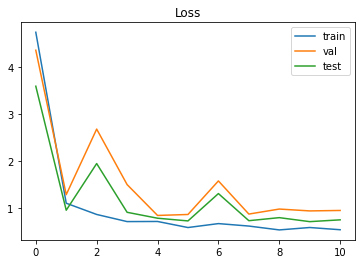

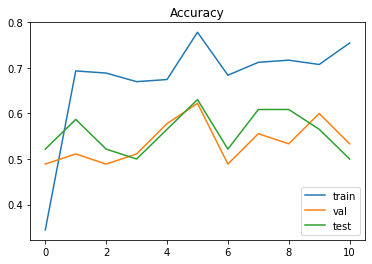

In [93]:
# Plot loss history
plt.title("Loss")
for split in ["train", "val", "test"]:
  plt.plot(history_loss[split], label=split)
plt.legend()
plt.show()

# Plot accuracy history
plt.title("Accuracy")
for split in ["train", "val", "test"]:
  plt.plot(history_accuracy[split], label=split)
plt.legend()
plt.show()

## Evaluation

In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in loaders['test']:
        inputs = data['image']
        labels = data['finding']
        outputs = model_ft(inputs.float().to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 54 %


In [23]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))


with torch.no_grad():
    for data in loaders['test']:
        images = data['image']
        labels = data['finding']
        outputs = model_ft(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of no-covid : 22 %
Accuracy of covid : 70 %


In [30]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(labels, np.argmax(output,1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("Confusion Matrix : ")
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Confusion Matrix : 
[[ 40  62]
 [ 38 163]]
acc: 0.6700
sensitivity: 0.3922
specificity: 0.8109
